In [1]:
from time import time
from enum import Enum

import nest_asyncio
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)
import gc

gc.collect()


2024-06-27 16:46:02.039895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 16:46:02.163522: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-27 16:46:02.163539: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-27 16:46:02.920722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

20

In [2]:
this_dir = Path.cwd()
print(this_dir)

# NUM_FEATURE = len(data_test_without_flow.columns) - 1
NUM_FEATURE = 512
NUM_PACKETS_PER_FLOW = 20
EPOCHS = 5
NUM_CLASSES = 4

EXPERIMENT_NAME = f"RUN-{NUM_PACKETS_PER_FLOW}-{NUM_FEATURE}"


MODEL_PATH = Path('/home/bkcs/Desktop/DOH-ONLY-CHROME-GOOGLE-20-512-REDUCED/model.h5')
# MODEL_PATH = this_dir / "results" / f"DED-{NUM_PACKETS_PER_FLOW}-{NUM_FEATURE}-NEW" / "model.keras"

print("Model path: ",  MODEL_PATH)

print('Number of features: ', NUM_FEATURE, ', Number of classes: ', NUM_CLASSES, ', Number of packets per flow: ',
      NUM_PACKETS_PER_FLOW)

/home/bkcs/Documents/doh/doh-exfiltration-detector
Model path:  /home/bkcs/Desktop/DOH-ONLY-CHROME-GOOGLE-20-512-REDUCED/model.h5
Number of features:  512 , Number of classes:  4 , Number of packets per flow:  20


# Load data

In [3]:

data_dir = this_dir


class Label(Enum):
    benign = 0
    dnscat2 = 1 
    dns2tcp = 2
    iodine = 3


datapath = Path("/home/bkcs/Downloads/Telegram Desktop/iodine_real.csv")

data = pd.read_csv(datapath, nrows=None)
data['label'] = Label['iodine'].value

print(str(data.groupby('flow_id').size().count()))

5073


# Get label

In [4]:
def most_frequent(flow):
    return max(set(flow), key=flow.count)

In [5]:
def get_label(data):
    grouped = data.groupby('flow_id')['label'].apply(list).to_dict()

    label = []
    for flow in grouped:
        label.append(most_frequent(grouped[flow]))

    return np.array(label)

In [6]:
label_test = np.array(get_label(data))

print('Label: ', len(label_test))

Label:  5073


In [7]:
# Drop number of rows per flow to NUM_PACKETS_PER_FLOW
def drop_rows(data):
    return data.groupby('flow_id').head(NUM_PACKETS_PER_FLOW)

data = drop_rows(data)

In [8]:
data_without_flow = data.drop('flow_id', axis=1)

In [9]:
x_test = np.expand_dims(
    (data_without_flow.drop('label', axis=1).iloc[:, :NUM_FEATURE].to_numpy() / 255).reshape(-1, NUM_PACKETS_PER_FLOW, NUM_FEATURE),
    axis=-1)

print('x_test shape: ', x_test.shape)

x_test shape:  (5073, 20, 512, 1)


# Load the model

In [10]:
model = tf.keras.models.load_model("/home/bkcs/Desktop/DOH-ONLY-CHROME-GOOGLE-20-512-REDUCED/model.h5")

model.summary()


2024-06-27 16:46:07.551156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-27 16:46:07.551173: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-27 16:46:07.551188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bkcs-Vostro-3668): /proc/driver/nvidia/version does not exist
2024-06-27 16:46:07.551332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 512, 32)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 512, 32)       25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 256, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 256, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 256, 64)       18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 256, 64)       36928     
                                                        

# Evaluate the model

In [11]:
def sec_to_hours(seconds):
    a = seconds // 3600
    b = (seconds % 3600) // 60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d

In [12]:
client_lr = 3e-4
NUM_ROUNDS = 300
BATCH_SIZE = 4

start = time()
predictions = model.predict(
    x_test, verbose=2, batch_size=BATCH_SIZE)
end = time() - start

1269/1269 - 26s - 26s/epoch - 20ms/step


In [13]:
flow_pred = np.argmax(predictions, axis=-1)

In [14]:
label_test

array([3, 3, 3, ..., 3, 3, 3])

In [15]:
flow_pred

array([0, 0, 0, ..., 0, 3, 0])

In [16]:
print(str((label_test == flow_pred).sum()/float(flow_pred.size)*100) + '%')

25.822984427360534%


/tmp/ipykernel_353941/180858245.py:32: RuntimeWarning: invalid value encountered in divide
  cm_perc = cm / cm_sum.astype(float) * 100


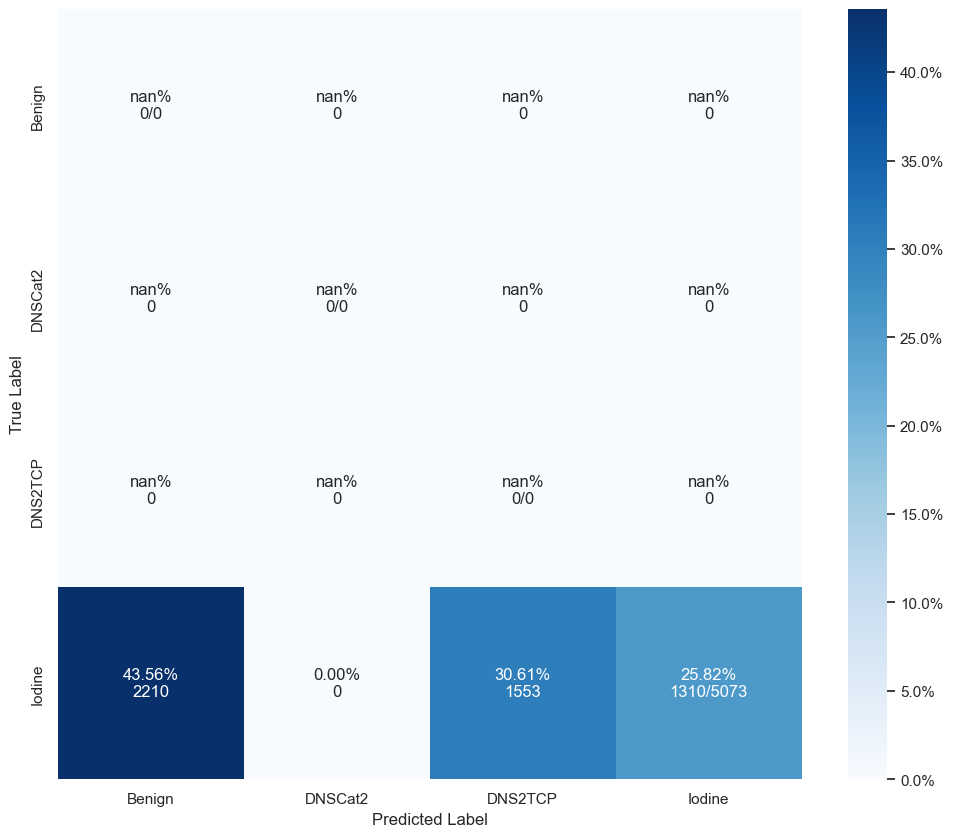

In [17]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def cm_analysis(y_true, y_pred, labels, classes, ymap=None, figsize=(17, 17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s[0])
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format': PercentFormatter()},
                yticklabels=classes, cmap="Blues")


cm_analysis(y_true=label_test, y_pred=flow_pred, labels=[0, 1, 2, 3],
            classes=['Benign', 'DNSCat2', 'DNS2TCP', 'Iodine'], figsize=(12, 10))